In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

# append parent directory to path (../notebooks -> ..) this cell should be run once. otherwise it goes one more level up
sys.path.append(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

import accelerate
import lovely_tensors as lt
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import torch.nn as nn
import wandb
import yaml
from diffusers.optimization import get_scheduler
from omegaconf import OmegaConf
from tqdm.auto import tqdm

from ldns.data.latent_attractor import get_attractor_dataloaders
from ldns.networks import AutoEncoder, CountWrapper
from ldns.utils.plotting_utils import *



lt.monkey_patch()
matplotlib.rc_file('matplotlibrc') # mackelab plotting style


CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.


In [2]:
# create config file

cfg_yaml = """
model:
  C_in: 128
  C: 256  # hidden layer channels from table 2
  C_latent: 8  # latent channels from table 2
  num_blocks: 4  # num blocks from table 2
  num_blocks_decoder: 0
  num_lin_per_mlp: 2
dataset:
  system_name: Lorenz
  signal_length: 256  # trial length from table
  n_ic: 5000  # 
  mean_rate: 0.3
  split_frac_train: 0.7
  split_frac_val: 0.1
  random_seed: 42
  softplus_beta: 2.0
training:
  lr: 0.001  # max learning rate from table
  weight_decay: 0.01  # AdamW weight decay from table
  num_epochs: 200  # num epochs from table
  num_warmup_epochs: 10  # num warmup epochs from table
  batch_size: 512  # batch size from table
  random_seed: 42
  precision: bf16
  latent_beta: 0.01  # L2 reg from table
  latent_td_beta: 0.01  # temporal smoothness from table
  mask_prob: 0.2  # CD mask prob from table
exp_name: autoencoder-Lorenz_z=8
"""

# omegaconf from yaml
cfg = OmegaConf.create(yaml.safe_load(cfg_yaml))
print(OmegaConf.to_yaml(cfg))

model:
  C_in: 128
  C: 256
  C_latent: 8
  num_blocks: 4
  num_blocks_decoder: 0
  num_lin_per_mlp: 2
dataset:
  system_name: Lorenz
  signal_length: 256
  n_ic: 5000
  mean_rate: 0.3
  split_frac_train: 0.7
  split_frac_val: 0.1
  random_seed: 42
  softplus_beta: 2.0
training:
  lr: 0.001
  weight_decay: 0.01
  num_epochs: 200
  num_warmup_epochs: 10
  batch_size: 512
  random_seed: 42
  precision: bf16
  latent_beta: 0.01
  latent_td_beta: 0.01
  mask_prob: 0.2
exp_name: autoencoder-Lorenz_z=8



In [ ]:

# set seed
torch.manual_seed(cfg.training.random_seed)
np.random.seed(cfg.training.random_seed)

train_dataloader, val_dataloader, test_dataloader = get_attractor_dataloaders(
    system_name=cfg.dataset.system_name,
    n_neurons=cfg.model.C_in,
    sequence_length=cfg.dataset.signal_length,
    n_ic=cfg.dataset.n_ic,
    mean_spike_count=cfg.dataset.mean_rate * cfg.dataset.signal_length,
    train_frac=cfg.dataset.split_frac_train,
    valid_frac=cfg.dataset.split_frac_val, # test is 1 - train - valid
    random_seed=cfg.training.random_seed,
    batch_size=cfg.training.batch_size,
    softplus_beta=cfg.dataset.get("softplus_beta", 2.0),
)

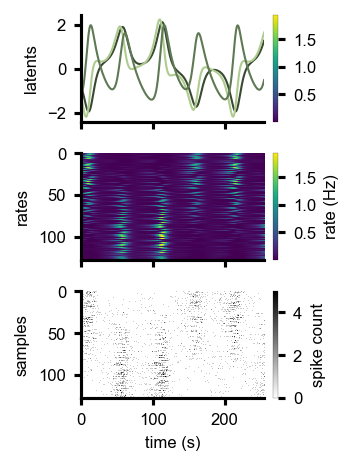

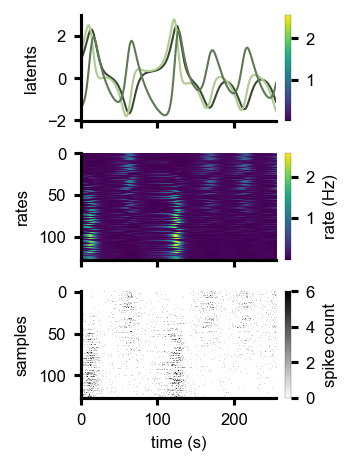

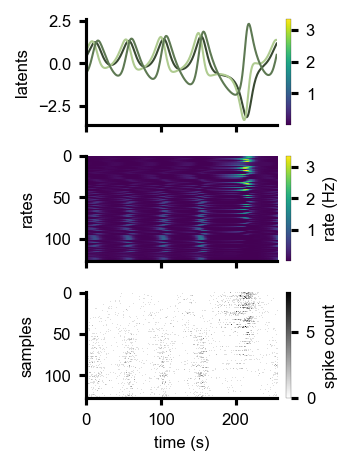

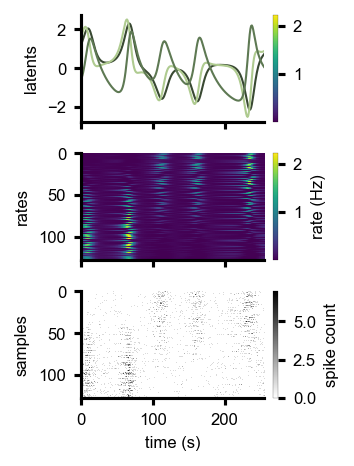

In [5]:
# visualize dataset

from ldns.utils.plotting_utils import plot_dataset_visualizations_order, cm2inch
plot_dataset_visualizations_order(train_dataloader.dataset.dataset, indices=[0, 1, 5, 90], figsize=cm2inch((6, 8)), green=True)

In [7]:
# define model, optimizer and learning rate scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ae = AutoEncoder(
    C_in=cfg.model.C_in,
    C=cfg.model.C,
    C_latent=cfg.model.C_latent,
    L=cfg.dataset.signal_length,
    num_blocks=cfg.model.num_blocks,
    num_blocks_decoder=cfg.model.num_blocks_decoder,
    num_lin_per_mlp=cfg.model.get("num_lin_per_mlp", 2),  # default 2
)

ae = CountWrapper(ae)

ae = ae.to(device)
optimizer = torch.optim.AdamW(
    ae.parameters(), lr=cfg.training.lr
)  # default wd=0.01 for now

num_batches = len(train_dataloader)
lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=num_batches * cfg.training.num_warmup_epochs,  # warmup for 10% of epochs
    num_training_steps=num_batches * cfg.training.num_epochs * 1.3,  # total number of steps, so it falls to 10% max at the end
)

# check if signal length is power of 2
if cfg.dataset.signal_length & (cfg.dataset.signal_length - 1) != 0:
    cfg.training.precision = "no"  # torch.fft doesnt support half if L!=2^x


# accelerate setup

accelerator = accelerate.Accelerator(
    mixed_precision=cfg.training.precision,
    log_with="wandb",
)

(
    ae,
    optimizer,
    lr_scheduler,
    train_dataloader,
    val_dataloader,
    test_dataloader,
) = accelerator.prepare(
    ae,
    optimizer,
    lr_scheduler,
    train_dataloader,
    val_dataloader,
    test_dataloader,
)

In [8]:
ae

CountWrapper(
  (ae_net): AutoEncoder(
    (encoder_in): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
    (encoder): ModuleList(
      (0-3): 4 x AutoEncoderBlock(
        (time_mixer): FFTConv(
          (activation): Identity()
          (kernel): SSMKernelDPLR()
          (drop): Identity()
          (drop_kernel): Identity()
        )
        (post_tm_scale): Conv1d(256, 256, kernel_size=(1,), stride=(1,), padding=same, groups=256)
        (channel_mixer): Sequential(
          (0): Rearrange('b c l -> b l c')
          (1): Linear(in_features=256, out_features=512, bias=False)
          (2): GELU(approximate='none')
          (3): Linear(in_features=512, out_features=256, bias=False)
          (4): Rearrange('b l c -> b c l')
        )
        (norm1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (act1): GELU(approximate='none')

# set up losses

In [9]:
from ldns.losses import latent_regularizer

criterion_poisson = nn.PoissonNLLLoss(log_input=False, full=True, reduction="none")

def compute_val_loss(net, dataloader):
    net.eval()
    poisson_loss_total = 0
    rates_loss_total = 0
    batch_count = 0

    for batch in dataloader:
        signal = batch["signal"]
        real_rates = batch["rates"]
        with torch.no_grad():
            output_rates = net(signal)[0].cpu()

        signal = signal.cpu()  # move signal to cpu
        real_rates = real_rates.cpu()

        # compute pointwise l2 loss
        poisson_loss = criterion_poisson(output_rates, signal)
        poisson_loss_total += poisson_loss.mean().item()
        rates_loss_total += ((output_rates - real_rates) ** 2).mean().item()

        batch_count += 1

    # compute average losses over all batches
    avg_poisson_loss = poisson_loss_total / batch_count * cfg.training.mask_prob

    fig, ax = plt.subplots(2, 1, figsize=cm2inch((10, 2)), dpi=300)
    for row in range(2):  # plot channels 0 and 71
        ax[row].plot(output_rates[0, 92 * (row)].cpu().clip(0, 3).numpy(), label="pred")
        ax[row].plot(
            batch["signal"][0, 92 * (row)].cpu().clip(0, 3).numpy(),
            label="spikes",
            alpha=0.5,
            color="grey",
        )
        ax[row].plot(
            batch["rates"][0, 71 * (row)].cpu().clip(0, 3).numpy(), label="real"
        )
        plt.legend()

    plt.close(fig)

    return avg_poisson_loss, rates_loss_total / batch_count


In [ ]:
# train loop

rec_losses, latent_losses, total_losses, lrs, val_rate_losses = [], [], [], [], []
avg_poisson_loss, avg_rate_loss = 0, 0

with tqdm(range(0, cfg.training.num_epochs)) as pbar:
    for epoch in pbar:
        ae.train()

        for i, data in enumerate(train_dataloader):
            optimizer.zero_grad()

            signal = data["signal"]

            # applying mask (coordinated dropout)
            mask_prob = cfg.training.get("mask_prob", 0.2)
            mask = (
                torch.rand_like(signal) > mask_prob
            ).float()  # if mask_prob=0.2, 80% will be 1 and rest 0
            input_signal = signal * (
                mask / (1 - mask_prob)
            )  # mask and scale unmasked by 1/(1-p)

            output_rates, z = ae(input_signal)

            numel = signal.shape[0] * signal.shape[1] * signal.shape[2]

            # computing loss on masked parts
            unmasked = (1 - mask) if mask_prob > 0 else torch.ones_like(mask)
            poisson_loss = criterion_poisson(output_rates, signal) * unmasked
            poisson_loss = poisson_loss.mean()

            rec_loss = poisson_loss

            latent_loss = latent_regularizer(z, cfg) / numel
            loss = rec_loss + cfg.training.latent_beta * latent_loss

            accelerator.backward(loss)
            accelerator.clip_grad_norm_(ae.parameters(), 2.0)

            optimizer.step()
            lr_scheduler.step()

            pbar.set_postfix(
                **{
                    "rec_loss": rec_loss.item(),
                    "latent_loss": latent_loss.item(),
                    "total_loss": loss.item(),
                    "lr": optimizer.param_groups[0]["lr"],
                    "epoch": epoch,
                    "val_poisson_loss": avg_poisson_loss,
                    "val_rate_loss": avg_rate_loss,
                }
            )
            rec_losses.append(rec_loss.item())
            latent_losses.append(latent_loss.item())
            total_losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]["lr"])
            

        # eval
        if accelerator.is_main_process and (
            (epoch + 1) % 5 == 0 or epoch == cfg.training.num_epochs - 1
        ):
            avg_poisson_loss, avg_rate_loss = compute_val_loss(ae, val_dataloader)
            val_rate_losses.append(avg_rate_loss)
            print(f"val Poisson loss: {avg_poisson_loss}, val rate vs. gt loss (l2): {avg_rate_loss}")
        if accelerator.is_main_process and epoch % 50 == 0:
            # plotting reconstructed rates across epochs
            plot_rec_rates(ae, val_dataloader) # from utils.plotting_utils

In [ ]:
# save model checkpoint
# optionally, save the best checkpoint according to val loss by keeping track of val loss and updating checkpoint

torch.save(accelerator.unwrap_model(ae).state_dict(), f"exp/{cfg.exp_name}/model.pt")

To train the diffusion model, we use the autoencoder latents in `notebooks/train_diffusion_Lorenz.ipynb`